In [8]:
from __future__ import print_function

import keras
from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.datasets import imdb
from keras import optimizers
from w2v import train_word2vec 
from keras.utils import np_utils

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

import numpy as np
import pandas as pd
import pickle, datetime

np.random.seed(0)

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [10]:
fname = '../Datasets/SST1_dataset/sst_data'
with open(fname, 'rb') as file:
    data = pickle.load(file)
    
x_train, y_train, x_test, y_test, dictionary = data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9645, 37) (9645, 5) (2210, 37) (2210, 5)


In [18]:
lstm_units = 128
batch_size = 32
embedding_dim = 300
vocab_size    = len(dictionary.token2id) + 1
max_sent_len  = dictionary.seq_len
dictionary_size = len(dictionary.keys())
N_CATEGORY = 5

In [20]:
embedding_wts = train_word2vec( np.vstack((x_train, x_test)), 
                                dictionary.id2token, num_features = embedding_dim)

model_input = Input(shape =  (max_sent_len, ))

z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, 
          name="embedding", trainable=True)(model_input)

z = LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)(z)
model_output = Dense(N_CATEGORY, activation='softmax')(z)

model = Model(model_input, model_output)
embedding_layer = model.get_layer("embedding")
embedding_layer.set_weights(embedding_wts)
model.summary()

Load existing Word2Vec model '300features_1minwords_10context'
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 37)                0         
_________________________________________________________________
embedding (Embedding)        (None, 37, 300)           3597600   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 3,817,893
Trainable params: 3,817,893
Non-trainable params: 0
_________________________________________________________________


In [21]:
from sklearn.metrics import roc_auc_score
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        pl.plot(self.acc, 'r')
        pl.plot(self.loss, 'g')
        pl.plot(self.val_acc, 'b')
        pl.plot(self.val_loss, 'k')
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [26]:
count = 0

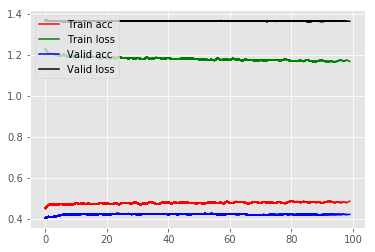

31s - loss: 1.1677 - acc: 0.4869 - val_loss: 1.3637 - val_acc: 0.4222


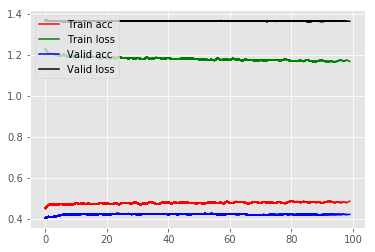

In [29]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(0.001), metrics=["accuracy"])

count += 1
histories = Histories()
res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=100,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

In [28]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 44.22%
Test Accuracy: 38.37%


In [24]:
def load_model(fname):
    model = keras.models.model_from_json(open(fname + '.json').read())
    model.load_weights(fname + '_weights.h5')
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=["accuracy"])
    return model

def save_model(model, fname):    
    json_string = model.to_json()
    open(fname + '.json', 'w').write(json_string)
    model.save_weights(fname + '_weights.h5', overwrite=True)
    with open( fname + '_history', 'wb') as output:
        pickle.dump([model.history.history], output, pickle.HIGHEST_PROTOCOL)

In [30]:
fname = './dodo_lstm' + str(count)
save_model(model, fname)
print(fname)

./dodo_lstm1


In [36]:
import pickle

# filename = './newtrain_CNN-rand_2017-04-08_16:29:11'
model = keras.models.load_model(filename + '.h5')

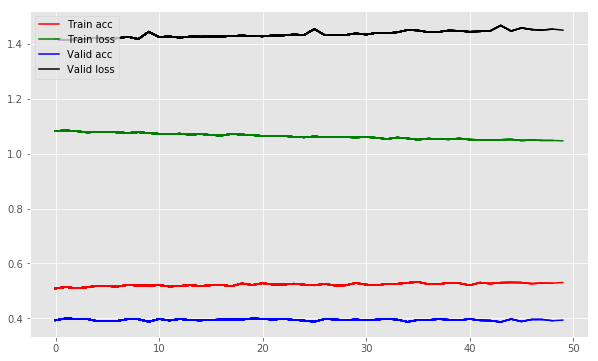

8s - loss: 1.0461 - acc: 0.5309 - val_loss: 1.4486 - val_acc: 0.3941


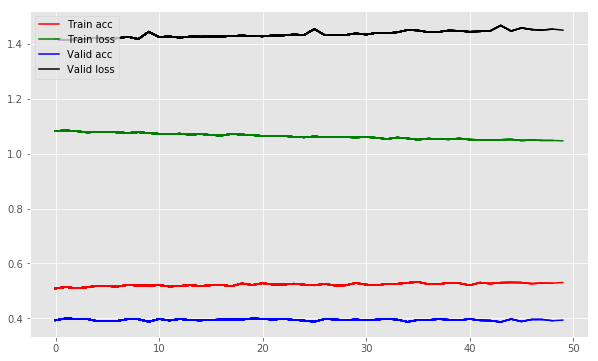

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(.001),
              metrics=['accuracy'])

histories = Histories()
res = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

In [38]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = './newtrain_continued_lstm'+ '_' + date + '_' +time

with open( filename + '_history', 'wb') as output:
    pickle.dump([model.history.history], output, pickle.HIGHEST_PROTOCOL)
    
model.save(filename + '.h5')

In [49]:
files = [
'newtrain_continued_lstm_2017-04-09_17:12:42_history',
    'newtrain_continued_lstm_2017-04-09_16:52:12_history',
'newtrain_lstm_2017-04-09_16:34:53_history'
]
files.reverse()

In [50]:
train_acc, train_loss, val_acc, val_loss = [],[],[],[]

for file in files:
    with open(file, 'rb') as input:
        out = pickle.load(input)
    hist = out[0]
    train_acc += hist['acc']
    train_loss += hist['loss']
    val_acc += hist['val_acc']
    val_loss += hist['val_loss']

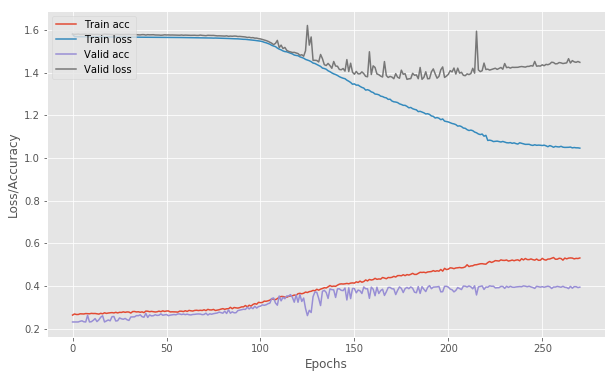

In [52]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()